# Preamble

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# %cd drive/My Drive/Recurrent Registration/

In [3]:
# !pip install neurite

## imports

In [126]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

import neurite as ne
from models.reg_rnn import REG_RNN
from utils import losses

# Data

## load

In [127]:
server = True  # False means Colab

if server:
    with open('/HDD/vxm-models/structured-data/unfiltered_images.pkl', 'rb') as f:
        pre_images = pickle.load(f)

    with open('/HDD/vxm-models/structured-data/unfiltered_labels.pkl', 'rb') as f:
        pre_labels = pickle.load(f)
        
    images, labels = [], []
    for ind, img in pre_images.items():
        inp = torch.from_numpy(img)
        p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
        images.append(p_inp)
        
    for ind, img in pre_labels.items():
        inp = torch.from_numpy(img)
        p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
        labels.append(p_inp)
        
else:  
    with open('./data/images', 'rb') as f:
        images = pickle.load(f)

    with open('./data/labels', 'rb') as f:
        labels = pickle.load(f)

## normalize

In [128]:
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()

for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

In [129]:
for i, imgs in enumerate(images):
    print(i, "-->", imgs.max(), labels[i].max())

0 --> tensor(1.) tensor(1.)
1 --> tensor(1.) tensor(1.)
2 --> tensor(1.) tensor(1.)
3 --> tensor(1.) tensor(1.)
4 --> tensor(1.) tensor(1.)
5 --> tensor(1.) tensor(1.)
6 --> tensor(1.) tensor(1.)
7 --> tensor(1.) tensor(1.)
8 --> tensor(1.) tensor(1.)
9 --> tensor(1.) tensor(1.)
10 --> tensor(1.) tensor(1.)
11 --> tensor(1.) tensor(1.)
12 --> tensor(1.) tensor(1.)
13 --> tensor(1.) tensor(1.)
14 --> tensor(1.) tensor(1.)
15 --> tensor(1.) tensor(1.)
16 --> tensor(1.) tensor(1.)
17 --> tensor(1.) tensor(1.)
18 --> tensor(1.) tensor(1.)
19 --> tensor(1.) tensor(1.)


## visualize

In [130]:
for i, imgs in enumerate(images):
    print(i, "-->", imgs.shape, labels[i].shape)
print()

0 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
1 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
2 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
3 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
4 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
5 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
6 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
7 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
8 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
9 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
10 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
11 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
12 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
13 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
14 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
15 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
16 --> torch.Size([40, 256, 256]) 

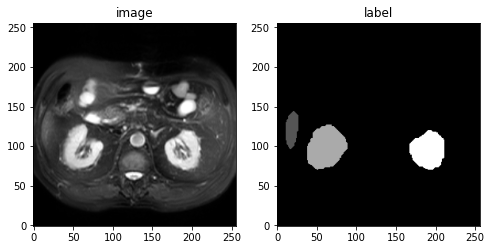

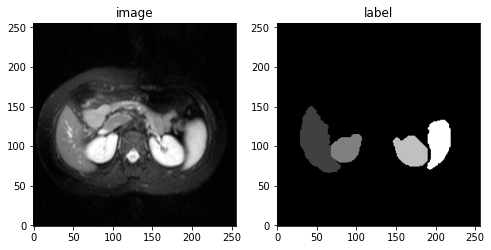

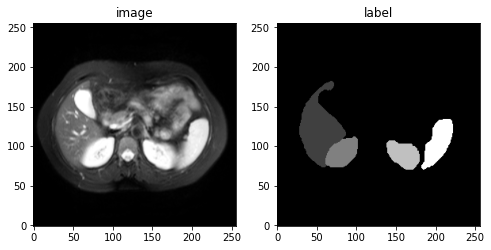

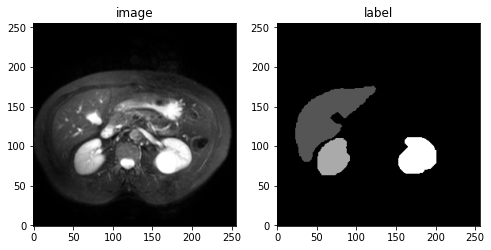

In [132]:
for pnum in (11, 12, 19, 3):
    patient_number = pnum
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    ax1.imshow(images[patient_number][15], origin='lower', cmap='gray')
    ax2.imshow(labels[patient_number][15], origin='lower', cmap='gray')
    ax1.set_title("image")
    ax2.set_title("label")

## dataloader

In [94]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)


def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=workers)
    
    return dataloader

# Args

In [95]:
class Args():
    def __init__(self):        
        self.lr = 0.01
        self.epochs = 20
        self.batch_size = 1
        self.smooth_weight = 0.01 
        self.seg_weight = 0
        self.loss = 'mse' 
        self.int_downsize = 2
        
args = Args()

# Run

## dataloader

In [63]:
dataloader = get_dataloader(images, labels, args.batch_size)

## model

In [64]:
model = REG_RNN(dataloader.dataset.image_size)
model.to('cuda')
# _ = model.train()

REG_RNN(
  (unet): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stri

## optimizer

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

## loss

In [18]:
if args.loss == 'ncc':
    sim_loss_func = losses.NCC().loss
elif args.loss == 'mse':
    sim_loss_func = losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

smooth_loss_func = losses.Grad('l2', loss_mult=args.int_downsize).loss
smooth_weight = args.smooth_weight

seg_loss_func = losses.MSE().loss
seg_weight = args.seg_weight

## train

In [49]:
loss_history = []
zero_phi = torch.zeros(39, 2, 256, 256).float().to('cuda')

for epoch in range(args.epochs):
    
    if epoch > 10:
        break

    epoch_loss = 0
    epoch_loss_sim = 0 
    epoch_loss_smooth = 0
    epoch_loss_seg = 0
    total_data_count = 0
    epoch_start_time = time.time()

    for d_idx, data in enumerate(dataloader):
        
#         if d_idx > 2:
#             break
        
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        

        # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        moved_imgs, moved_lbs, flows = model(imgs, lbs)
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
#         ax1.imshow(flows[3].squeeze(0).squeeze(0)[0].detach().cpu())
#         ax2.imshow(flows[3].squeeze(0).squeeze(0)[1].detach().cpu())
        
        # calculate loss
        loss = 0
        for i in range(bs):
            sim_loss = sim_loss_func(imgs[1:, i], moved_imgs[:, i])
            smooth_loss = smooth_loss_func(zero_phi, flows[:, i])
            seg_loss = seg_loss_func(lbs[1:, i], moved_lbs[:, i])
            loss = sim_loss + (smooth_weight * smooth_loss) + (seg_weight * seg_loss)

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update epoch loss
        epoch_loss += loss * bs
        epoch_loss_sim += sim_loss * bs
        epoch_loss_smooth += smooth_loss * bs
        epoch_loss_seg += seg_loss * bs
        total_data_count += bs 
    
    # print epoch info
    loss_history.append(epoch_loss / total_data_count)
    msg = 'epoch %d/%d, ' % (epoch + 1, args.epochs)
    msg += 'loss= %.4e, ' % (epoch_loss / total_data_count)
    msg += 'sim_loss= %.4e, ' % (epoch_loss_sim / total_data_count)
    msg += 'smooth_loss= %.4e, ' % (epoch_loss_smooth)
    msg += 'seg_loss= %.4e, ' % (epoch_loss_seg / total_data_count)
    msg += 'time= %.4f, ' % (time.time() - epoch_start_time)
    print(msg, flush=True)
    

epoch 1/20, loss= 5.1330e-03, sim_loss= 5.1330e-03, smooth_loss= 6.5876e-06, seg_loss= 4.6752e-03, time= 5.9548, 
epoch 2/20, loss= 5.1252e-03, sim_loss= 5.1252e-03, smooth_loss= 1.2111e-05, seg_loss= 4.6621e-03, time= 5.9481, 
epoch 3/20, loss= 5.0942e-03, sim_loss= 5.0942e-03, smooth_loss= 8.0496e-05, seg_loss= 4.6090e-03, time= 5.9575, 
epoch 4/20, loss= 5.0486e-03, sim_loss= 5.0483e-03, smooth_loss= 6.9152e-04, seg_loss= 4.5325e-03, time= 5.9682, 


KeyboardInterrupt: 

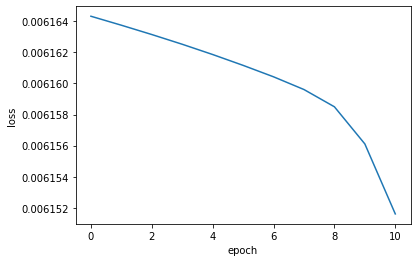

In [40]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## evaluate

In [121]:
with open('/HDD/vxm-models/structured-data/filtered_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)

with open('/HDD/vxm-models/structured-data/filtered_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)
    
images, labels = [], []
for ind, img in pre_images.items():
    images.append(torch.from_numpy(img))

for ind, img in pre_labels.items():
    labels.append(torch.from_numpy(img))

        
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()

for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()
    
    
dataloader = get_dataloader(images, labels, args.batch_size)

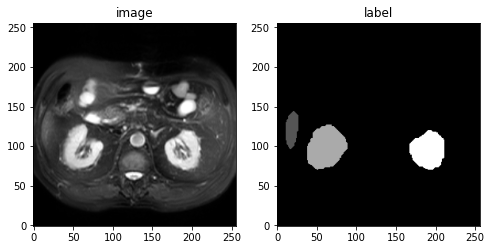

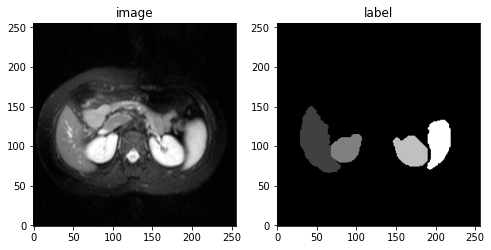

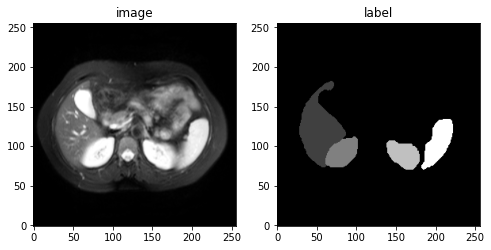

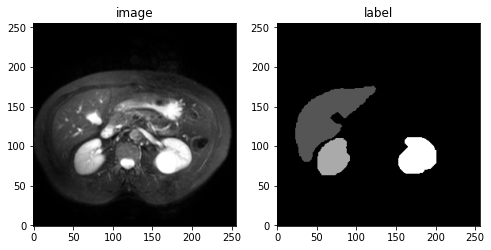

In [133]:
for pnum in (11, 12, 19, 3):
    patient_number = pnum
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    ax1.imshow(images[patient_number][15], origin='lower', cmap='gray')
    ax2.imshow(labels[patient_number][15], origin='lower', cmap='gray')
    ax1.set_title("image")
    ax2.set_title("label")

In [134]:
base = '/HDD/kian/rnn-registration/saved-models/'
model_folder = '6/'
snap_shot = '0400'
PATH = f'{base}{model_folder}{snap_shot}.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [135]:
model.eval()

dice_loss_func = losses.Dice().loss

0.8670007 0.84923375 0.85415 0.87007535 0.8420632 0.8637594 0.8668313 0.8754371 0.8750051 0.8294825 0.83631283 0.86538553 0.8509716 0.8970693 0.8660811 0.86115044 0.8553752 0.8398114 0.8871785 0.8569679 mean: 0.86046714 , std: 0.016331661


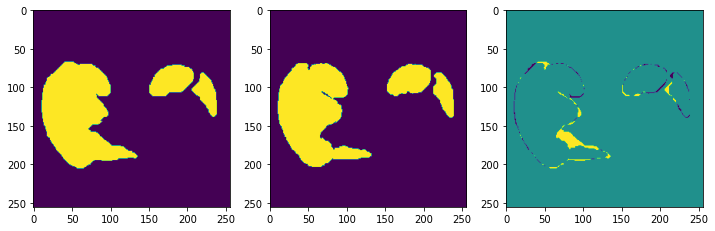

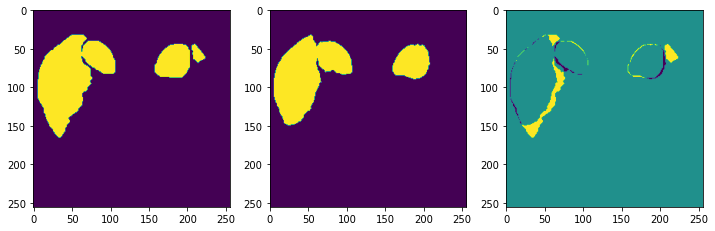

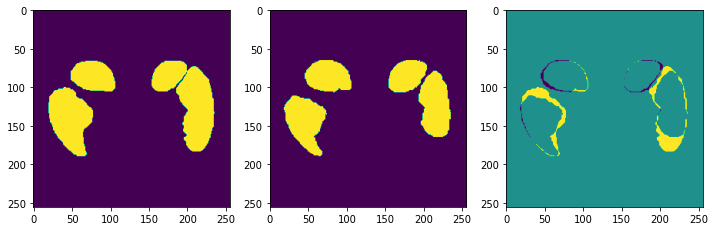

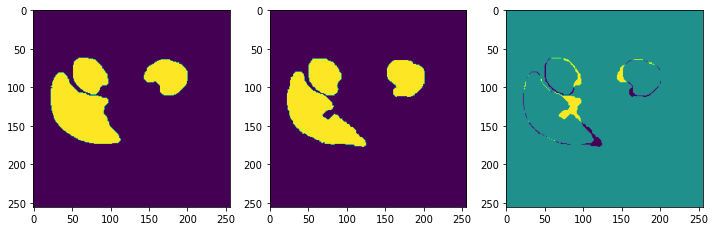

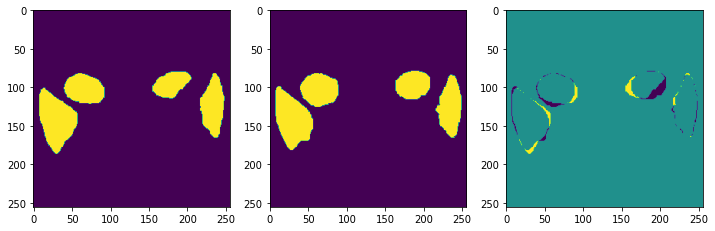

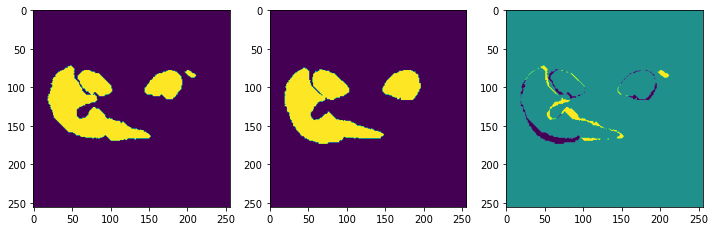

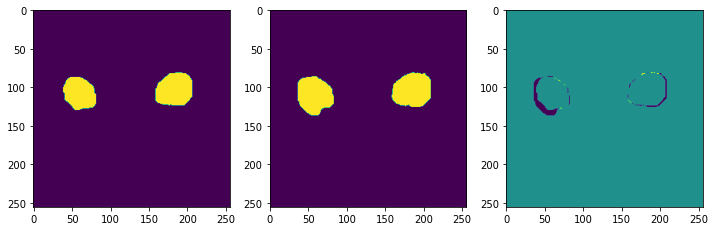

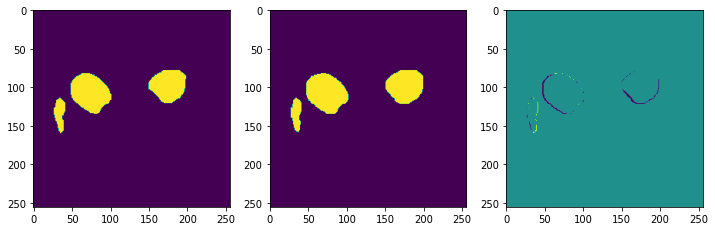

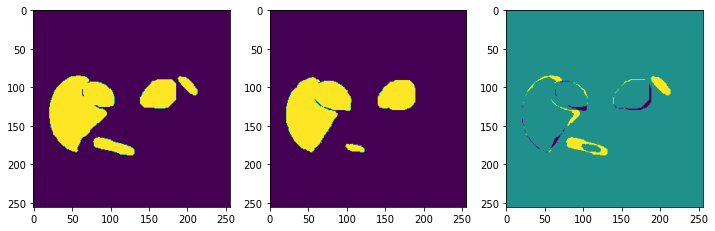

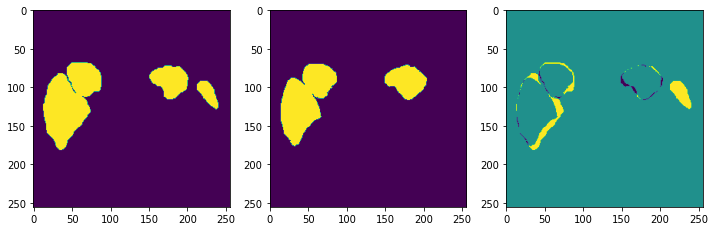

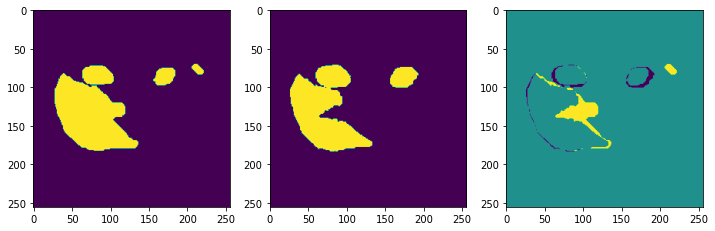

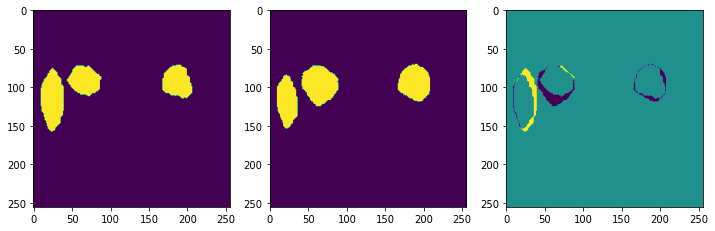

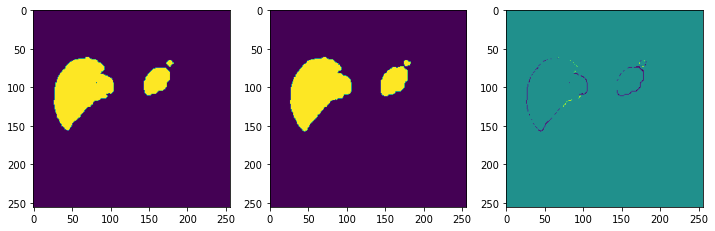

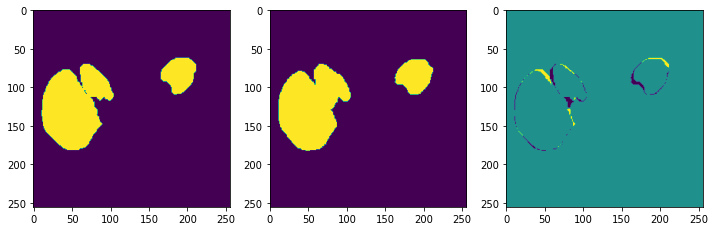

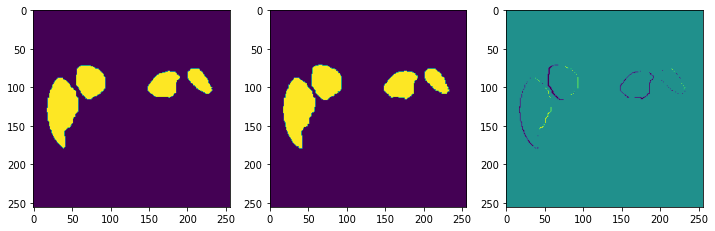

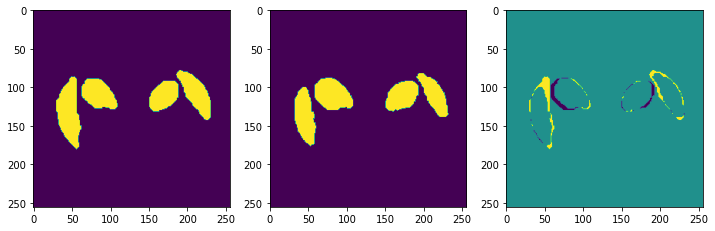

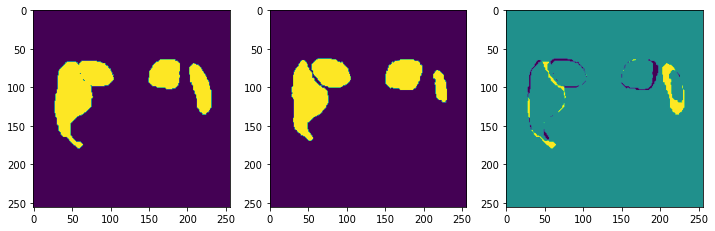

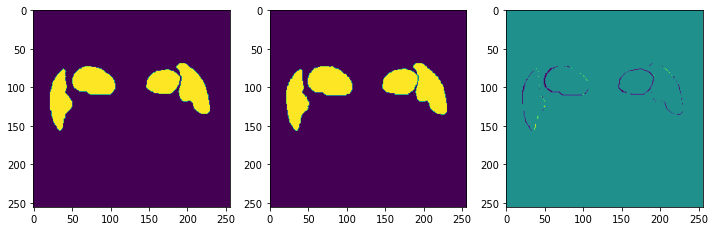

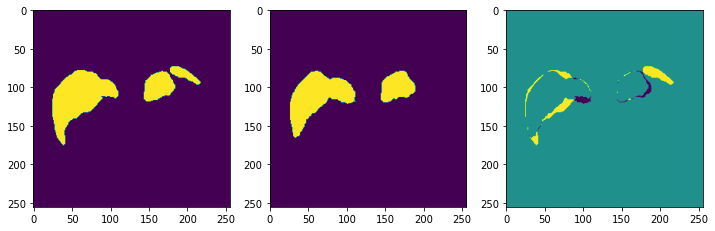

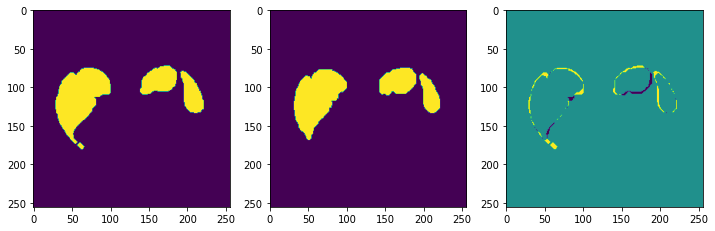

In [143]:
dice_score = []
for data in dataloader:
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        
        # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        with torch.no_grad():
            moved_imgs, moved_lbs, flows = model(imgs, lbs)
        
        for i in range(bs):
            zero = torch.zeros_like(lbs[1:, i]).to('cuda')
            one = torch.ones_like(lbs[1:, i]).to('cuda')
            fixed_lbs_ = torch.where(lbs[1:, i] > 0, one, zero)
            moved_lbs_ = torch.where(moved_lbs[:, i] > 0, one, zero)

            # exclude padding
            labeled = []
            for k in range(fixed_lbs_.shape[0]):
                if fixed_lbs_[k].max() != 0.0 and moved_lbs_[k].max() != 0.0:
                    labeled.append(k)
            fixed_lbs_ = fixed_lbs_[labeled]
            moved_lbs_ = moved_lbs_[labeled]          
            dd = (-dice_loss_func(fixed_lbs_, moved_lbs_)).detach().cpu().numpy()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
            ax1.imshow(fixed_lbs_[10].squeeze(0).cpu())
            ax2.imshow(moved_lbs_[10].squeeze(0).cpu())
            ax3.imshow(fixed_lbs_[10].squeeze(0).cpu() - moved_lbs_[10].squeeze(0).cpu())
            print(dd, end=' ')

            dice_score.append(dd)

print('mean:', np.mean(dice_score), ', std:', np.std(dice_score))

In [137]:
import json
tmet = json.load(open(f'{base}{model_folder}/train_metrics.json'))

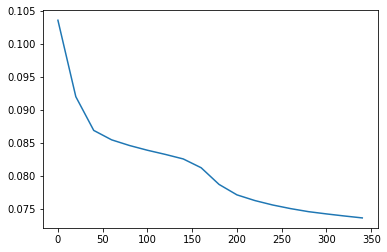

In [139]:
eps, loss = [], []
for m in tmet:
    eps.append(m.get('epoch'))
    loss.append(m.get('epoch_loss'))
plt.plot(eps, loss);

## visualize

In [140]:
def visualize(dataloader, patient_num, slice_ids=[], model=None):

    for i, data in enumerate(dataloader):
        if i != patient_num:
            continue
        
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

        if model is not None:
            model.eval();
            with torch.no_grad():
                # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
                # shape of flows: (seq_size - 1, bs, 2, W, H)
                moved_imgs, moved_lbs, flows = model(imgs, lbs)
                moved_imgs = moved_imgs.detach().cpu().numpy()
                moved_lbs = moved_lbs.detach().cpu().numpy()
                flows = flows.detach().cpu().numpy()

        imgs = imgs.detach().cpu().numpy()
        lbs = lbs.detach().cpu().numpy()

        # images
        moving_imgs = imgs[:-1, 0, 0]
        fixed_imgs = imgs[1:, 0, 0]
        moved_imgs = moving_imgs if model is None else moved_imgs[:, 0, 0]

        # labels
        moving_lbs = lbs[:-1, 0, 0]
        fixed_lbs = lbs[1:, 0, 0]
        moved_lbs = moving_lbs if model is None else moved_lbs[:, 0, 0]

        flows = torch.zeros((39, 256, 256)).numpy() if model is None else flows[:, 0, 0]

        # visualize
        for k in slice_ids:            
            # images 
            pics = [pic[k] for pic in [moving_imgs, fixed_imgs, moved_imgs, flows]] 
            titles = ['moving_img', 'fixed_img', 'moved_img', 'flow']
            ne.plot.slices(pics, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);
            # labels 
            pics = [pic[k] for pic in [moving_lbs, fixed_lbs, moved_lbs, flows]] 
            titles = ['moving_lb', 'fixed_lb', 'moved_lb', 'flow']
            ne.plot.slices(pics, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);
            
            fixed_lb = torch.tensor(fixed_lbs[k]).unsqueeze(0).unsqueeze(0)
            moved_lb = torch.tensor(moved_lbs[k]).unsqueeze(0).unsqueeze(0)
            one = torch.ones_like(fixed_lb)
            zero = torch.zeros_like(fixed_lb)
            fixed_lb = torch.where(fixed_lb > 0, one, zero)
            moved_lb = torch.where(moved_lb > 0, one, zero)

            print('dice_score:', -dice_loss_func(fixed_lb, moved_lb).detach().cpu().numpy())

        break

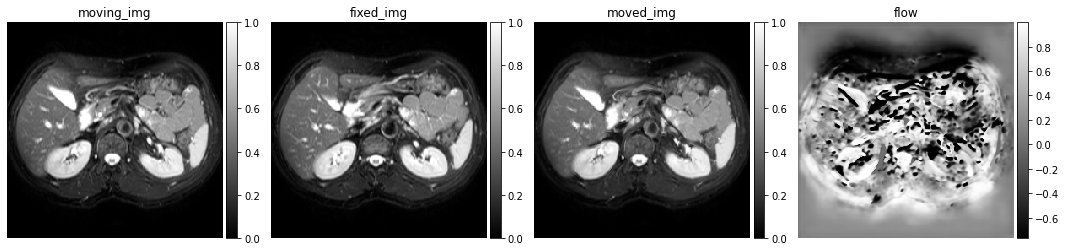

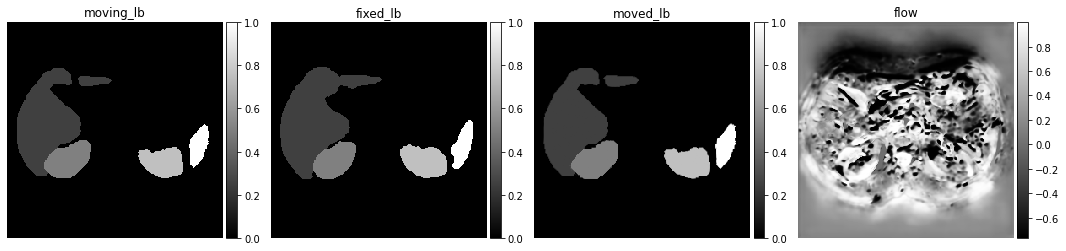

dice_score: 0.9396245


In [142]:
score = visualize(dataloader, patient_num=0, slice_ids=[9], model=model)              

In [2]:
a = [1, 2]
a[-1:]

[2]